In [1]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)

# Load Data

In [3]:
# Returns one dataframe containing all json in data folder
def load_all_user_json():
    dataframes = []
    pattern = r"UserTimeline_(\w+)\.json"
    
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match is not None:
            temp_df = pd.read_json(f"data/{filename}", convert_dates = ["created_at"])
            temp_df["username"] = match.group(1)
            dataframes.append(temp_df)
    
    results = pd.concat(dataframes)
    results = results[['username'] + list(results.columns[:-1])]
    return results

    
df = load_all_user_json()
df

# Use this if running from jupyter notebook
# def load_all_user_json():
#     dataframes = []
#     pattern = r"UserTimeline_(\w+)\.json"
    
#     for filename in os.listdir():
#         if (filename == '.config' or filename == 'sample_data'):
#           continue
#         match = re.search(pattern, filename)
#         print(match)
#         temp_df = pd.read_json(f"{filename}", convert_dates = ["created_at"])
#         temp_df["username"] = match.group(1)
#         dataframes.append(temp_df)
    
#     results = pd.concat(dataframes)
#     results = results[['username'] + list(results.columns[:-1])]
#     return results

df = load_all_user_json()
df

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1619795017714786307, 'id_str...",NaN
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
3248,TheOnion,2023-01-29 20:00:10+00:00,1619787507414990849,1619787507414990848,Deebo Samuel: The electric wideout led the lea...,True,"{'hashtags': [], 'symbols': [], 

# Process Data

In [4]:
# Pulls "day of the week" and "hour of the day" from `created_at`
def process_dates(df):
    temp_df = df.copy()
    
    temp_df["day_of_week"] = df["created_at"].dt.day_name()
    temp_df["hour_of_day"] = df["created_at"].dt.hour
    
    return temp_df


df = process_dates(df)
df

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,21
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,20
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN,Friday,20
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,19
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1619795017714786307, 'id_str...",NaN,Sunday,20
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20
3248,TheOnion,2023-01-29 20:00:10+00:00,1619787507414990

In [5]:
# Average Engagement Rate: 
# Measures the number of engagements a content gets to the percentage of audience. 

# Average engagement rate = (likes + shares) / total followers
def process_avg_engagement_rate(df):
    temp_df = df.copy()
    
    temp_df["avg_engagement_rate"] = temp_df.apply(lambda row : (row["favorite_count"] + row["retweet_count"]) / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_avg_engagement_rate(df)

In [6]:
# Amplification Rate:
# Measures the ratio of shares per post to the number of overall followers. 

def process_amplification_rate(df): 
    temp_df = df.copy()

    temp_df["amplification_rate"] = temp_df.apply(lambda row : row["retweet_count"] / row["user"]["followers_count"], axis = 1)
    return temp_df

df = process_amplification_rate(df)


# Basic Functions

In [7]:
# Given a pandas series, return the link of the tweet
def get_tweet_link(series):
    username = series["user"]["screen_name"]
    return f"https://twitter.com/{username}/status/{series['id']}"

tweet_link = get_tweet_link(df.iloc[0])
tweet_link

'https://twitter.com/HardDriveMag/status/1664738765376573442'

In [8]:
def find_retweets(df):
    return df[df["retweeted_status"].notnull()]

df_retweets = find_retweets(df)
df_retweets

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
1,HardDriveMag,2023-06-02 20:40:39+00:00,1664733790114127873,1664733790114127872,"RT @Whemn1: The Day I stopped following Cain, ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,66,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:28:26 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,20,0.000205,0.000205
2,HardDriveMag,2023-06-02 20:40:10+00:00,1664733668525441025,1664733668525441024,RT @jeremysmiles: ATHEISTS: can you tackle thi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,129,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 20:30:52 +0000 2023...,1.663208e+18,1.663208e+18,NaN,NaN,Friday,20,0.000400,0.000400
4,HardDriveMag,2023-06-02 18:53:58+00:00,1664706941015281673,1664706941015281664,RT @pancarialice: yeah us jerma fans don’t rea...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,153,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 18:12:15 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,18,0.000475,0.000475
5,HardDriveMag,2023-06-02 17:46:29+00:00,1664689958307725313,1664689958307725312,RT @HardDriveMag: @elonmusk Elon Musk’s Daught...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,74,0,False,False,0.0,en,{'created_at': 'Fri Jun 02 17:31:55 +0000 2023...,NaN,NaN,NaN,NaN,Friday,17,0.000230,0.000230
9,HardDriveMag,2023-06-02 16:15:23+00:00,1664667033278074881,1664667033278074880,RT @jothwip: It's still hard to believe it's b...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,True,115,0,False,False,NaN,en,{'created_at': 'Fri Jun 02 13:02:57 +0000 2023...,1.664618e+18,1.664618e+18,NaN,NaN,Friday,16,0.000357,0.000357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105,TheOnion,2023-04-21 15:23:33+00:00,1649433698528370690,1649433698528370688,RT @KartoonistKelly: I call out the anniversar...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,39,0,False,False,0.0,en,{'created_at': 'Thu Apr 20 17:53:31 +0000 2023...,NaN,NaN,NaN,NaN,Friday,15,0.000003,0.000003
1336,TheOnion,2023-04-13 16:07:54+00:00,1646545758059896832,1646545758059896832,RT @KartoonistKelly: Class.\nMy latest:\nhttps...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,169,0,False,False,0.0,en,{'created_at': 'Mon Apr 10 17:44:58 +0000 2023...,NaN,NaN,NaN,NaN,Thursday,16,0.000014,0.000014
1355,TheOnion,2023-04-12 21:06:16+00:00,1646258454133104644,1646258454133104640,RT @KartoonistKelly: During his time of TRIAL ...,Fa

In [9]:
def find_not_retweets(df):
    return df[df["retweeted_status"].isna()]

df_not_retweets = find_not_retweets(df)
df_not_retweets

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
0,HardDriveMag,2023-06-02 21:00:25+00:00,1664738765376573442,1664738765376573440,EA Honors Pride Month by Announcing One of the...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,674,7302,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,21,0.024750,2.091453e-03
3,HardDriveMag,2023-06-02 19:00:54+00:00,1664708687003373590,1664708687003373568,BREAKING: Nintendo Announces Mario Will “Try a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,2275,20306,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,19,0.070070,7.059430e-03
6,HardDriveMag,2023-06-02 17:31:55+00:00,1664686295157813248,1664686295157813248,@elonmusk Elon Musk’s Daughter Tells Him She W...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.664615e+18,1.664615e+18,44196397.0,44196397.0,elonmusk,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,74,779,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,17,0.002647,2.296254e-04
7,HardDriveMag,2023-06-02 17:26:16+00:00,1664684871132774409,1664684871132774400,Diablo Fans Happy Blizzard Kept Iconic Feature...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,176,1600,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1664684868138041372, 'id_str...",NaN,Friday,17,0.005511,5.461361e-04
8,HardDriveMag,2023-06-02 17:00:54+00:00,1664678486370287628,1664678486370287616,Retired Angry Bird Diagnosed With CTE\n\nhttps...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,NaN,NaN,None,"{'id': 867929010877190144, 'id_str': '86792901...",NaN,NaN,NaN,NaN,False,38,720,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,17,0.002352,1.179157e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,TheOnion,2023-01-29 20:35:05+00:00,1619796295891226624,1619796295891226624,Nick Bosa: The defensive end fully utilizes hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,2,66,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Sunday,20,0.000006,1.698947e-07
3246,TheOnion,2023-01-29 20:30:06+00:00,1619795038451515393,1619795038451515392,Nick Bosa Quietly Admits To Offensive Tackle T...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,46,630,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1619795017714786307, 'id_str...",NaN,Sunday,20,0.000057,3.907577e-06
3247,TheOnion,2023-01-29 20:15:06+00:00,1619791266887131139,1619791266887131136,A.J. Brown: The Eagles receiver has it all: ha...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,NaN,NaN,NaN,None,"{'id': 14075928, 'id_str': '14075928', 'name':...",NaN,NaN,NaN,NaN,False,36,317,Fa

# Basic Metrics

### Top Tweets

In [10]:
# Top 5 tweets with most likes (favorited)
def most_liked_tweets(df, count):
    return df.sort_values(by = ["favorite_count"], ascending = False).head(count)


def most_liked_tweets_by_users(df, count = 5):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        results[username] = most_liked_tweets(df[df["username"] == username], count)
    return results
    

dfs_top5 = most_liked_tweets_by_users(df, 5)
dfs_top5["Reductress"]

,username,created_at,id,id_str,text,truncated,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,day_of_week,hour_of_day,avg_engagement_rate,amplification_rate
2382,Reductress,2022-09-08 17:31:01+00:00,1567928508218736640,1567928508218736640,Cute! Queen Elizabeth's Corgis Prepare to Be B...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,24404,212457,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1567928506117398528, 'id_str...",NaN,Thursday,17,0.776991,0.080054
2673,Reductress,2022-08-05 22:00:43+00:00,1555675190394232834,1555675190394232832,Wow! This Middle Aged Man Fell In Love With Hi...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,5025,51690,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN,Friday,22,0.186046,0.016484
2538,Reductress,2022-08-21 16:00:25+00:00,1561382724442652673,1561382724442652672,Nice! New Collar Delivers a Shock Every Time Y...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,3327,28908,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1561382722693627907, 'id_str...",NaN,Sunday,16,0.105743,0.010914
1930,Reductress,2022-10-29 21:00:17+00:00,1586462954102624256,1586462954102624256,How to Pass Off Your IBS Bathroom Trips as a C...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1663,19245,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1586462952747573250, 'id_str...",NaN,Saturday,21,0.068586,0.005455
1010,Reductress,2023-02-11 22:00:23+00:00,1624528804377989120,1624528804377989120,Quadruple Threat! Barbra Streisand Has a Knife...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://www.hootsuite.com"" rel=""nofol...",NaN,NaN,NaN,NaN,None,"{'id': 1090026433, 'id_str': '1090026433', 'na...",NaN,NaN,NaN,NaN,False,1504,14852,False,False,0.0,en,NaN,NaN,NaN,"{'media': [{'id': 1624528803153252354, 'id_str...",NaN,Saturday,22,0.053654,0.004934


In [11]:
get_tweet_link(dfs_top5["HardDriveMag"].iloc[0])

'https://twitter.com/HardDriveMag/status/1531401966567493634'

In [12]:
def find_average_by_users(dataframes, column_name, avg_type = "mean"):
    usernames = pd.unique(df["username"])
    results = {}
    for username in usernames:
        if avg_type == "mean":
            results[username] = df[df["username"] == username][column_name].mean()
        elif avg_type == "median":
            results[username] = df[df["username"] == username][column_name].median()
    return results


print("Mean favorites   : ")
for username, mean in find_average_by_users(df_not_retweets, "favorite_count", "mean").items():
    print(f"{username:16} : {mean:.2f}")

print("-----\n")

print("Median favorites : ")
for username, median in find_average_by_users(df_not_retweets, "favorite_count", "median").items():
    print(f"{username:16} : {median}")

Mean favorites   : 
HardDriveMag     : 2877.49
Reductress       : 707.47
TheBabylonBee    : 6833.81
TheOnion         : 1848.31
-----

Median favorites : 
HardDriveMag     : 1545.0
Reductress       : 385.0
TheBabylonBee    : 3295.0
TheOnion         : 805.0


## Metrics for Monitoring 

### Engagement Rate

In [19]:
print("Mean engagement rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "avg_engagement_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median engagement rate   : ")
for username, median in find_average_by_users(df_not_retweets, "avg_engagement_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean engagement rate   : 
HardDriveMag     : 0.009977
Reductress       : 0.002555
TheBabylonBee    : 0.002942
TheOnion         : 0.000172
-----

Median engagement rate   : 
HardDriveMag     : 0.005253
Reductress       : 0.001389
TheBabylonBee    : 0.001422
TheOnion         : 0.000073


### Amplification Rate

In [83]:
print("Mean amplification rate   : ")
for username, mean in find_average_by_users(df_not_retweets, "amplification_rate", "mean").items():
    print(f"{username:16} : {mean:.6f}")
    
print("-----\n")

print("Median amplification rate   : ")
for username, median in find_average_by_users(df_not_retweets, "amplification_rate", "median").items():
    print(f"{username:16} : {median:.6f}")

Mean amplification rate   : 
HardDriveMag     : 0.001048
Reductress       : 0.000234
TheBabylonBee    : 0.000394
TheOnion         : 0.000015
-----

Median amplification rate   : 
HardDriveMag     : 0.000416
Reductress       : 0.000121
TheBabylonBee    : 0.000163
TheOnion         : 0.000005


In [84]:
def find_average_tweet_engagement_by_time(dataframes):
    usernames = pd.unique(df["username"])
    results = {}
    
    for username in usernames: 
        subset_df = dataframes[dataframes["username"] == username]  
        retweet_counts = subset_df.groupby('hour_of_day')['avg_engagement_rate'].sum()
        result_dict = retweet_counts.to_dict()
        results[username] = result_dict
    return results

print('Average Tweet Engagement by Time')
test = find_average_tweet_engagement_by_time(df_not_retweets)
for key, value in test.items():
    print(key)
    print(f'Hour : Avg Engagement Rate')
    for key2, value2 in value.items():
        print(f'{key2:2d}   : {value2:0.6f}')
    print()

Average Tweet Engagement by Time
HardDriveMag
Hour : Avg Engagement Rate
 0   : 0.944127
 1   : 0.220394
 2   : 0.500974
 3   : 0.125189
 4   : 0.425927
 5   : 0.031912
 6   : 0.004748
 8   : 0.009973
11   : 0.000717
12   : 0.054471
13   : 3.201462
14   : 1.823238
15   : 2.712894
16   : 1.840640
17   : 4.180321
18   : 2.658091
19   : 3.591664
20   : 2.156657
21   : 2.910421
22   : 2.209133
23   : 1.970965

Reductress
Hour : Avg Engagement Rate
 0   : 0.004940
 1   : 0.002378
 2   : 0.002155
12   : 0.000128
13   : 0.011025
14   : 0.992849
15   : 0.698682
16   : 1.039036
17   : 1.552046
18   : 0.904896
19   : 0.647833
20   : 0.729455
21   : 1.068625
22   : 0.622568
23   : 0.022041

TheBabylonBee
Hour : Avg Engagement Rate
 0   : 0.285959
 1   : 0.171199
 2   : 0.122337
 3   : 0.045616
 4   : 0.008363
 5   : 0.002764
 9   : 0.000478
11   : 0.024321
12   : 0.296607
13   : 0.550536
14   : 0.629248
15   : 0.544258
16   : 0.805074
17   : 0.746887
18   : 0.981919
19   : 0.825145
20   : 0.78097

# Plots

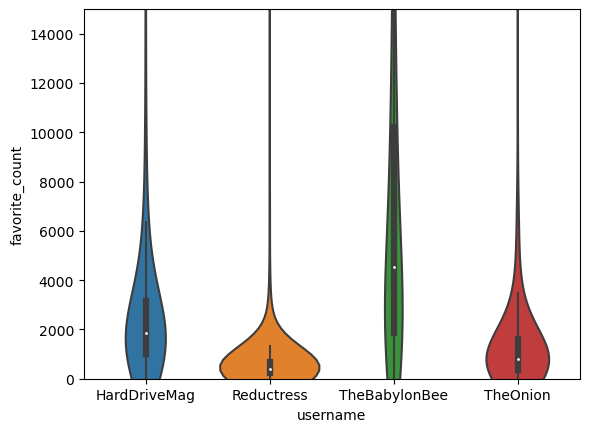

In [85]:
# Plot favorite count of each user using a violin plot
def plot_favorite_count_by_user(df):
    fig, ax = plt.subplots()
    sns.violinplot(data = df, x = "username", y = "favorite_count", gridsize = 1000)
    ax.set_ylim(0, 15000)
    plt.show()
    
    
plot_favorite_count_by_user(df_not_retweets)

In [86]:
# Plot 4 subplots of counts of tweets by hour of the day
def plot_tweet_counts(df, column_name, order):
    grid = sns.FacetGrid(data = df, col = "username", col_wrap = 2, aspect = 1.5, height = 4, sharex = False, sharey = False)
    
    grid.map(sns.countplot, column_name, order = order)
    grid.set_axis_labels(column_name, "Count")
    grid.set_titles('{col_name}')
    plt.subplots_adjust(hspace=0.4)
    
    plt.show()

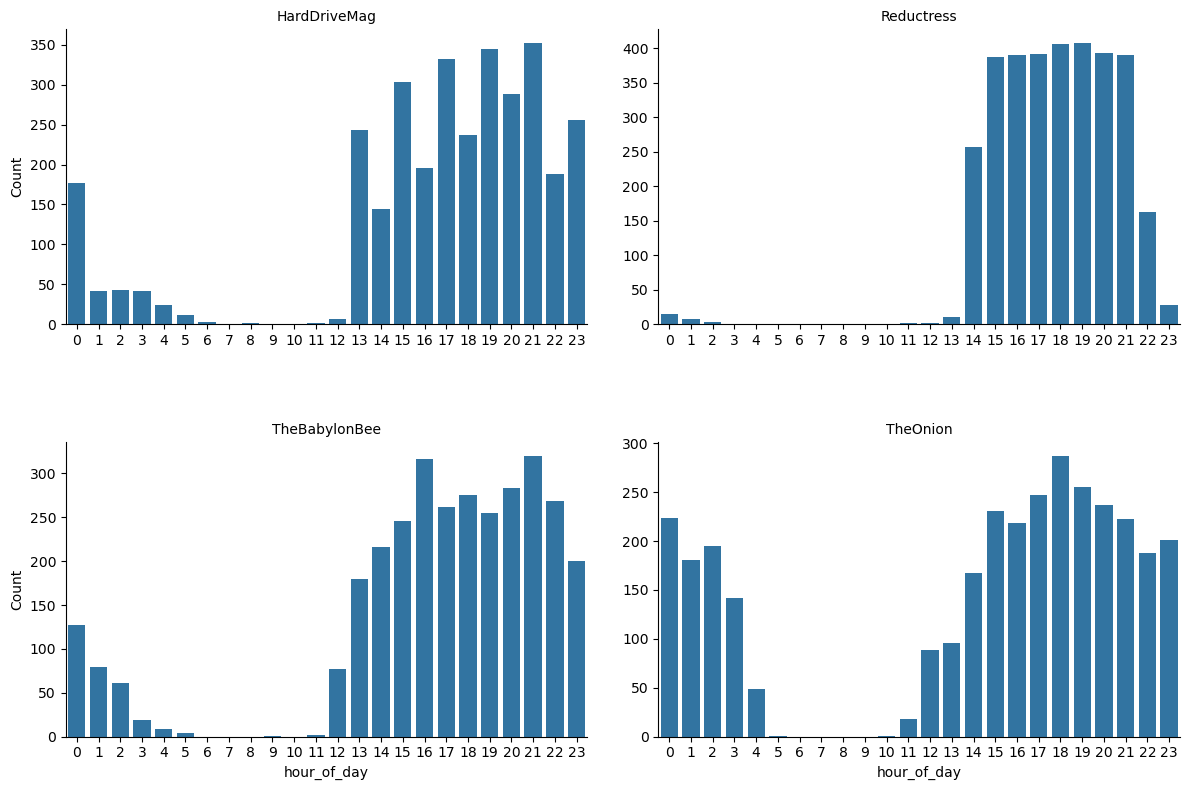

In [87]:
plot_tweet_counts(df, "hour_of_day", [i for i in range(24)])

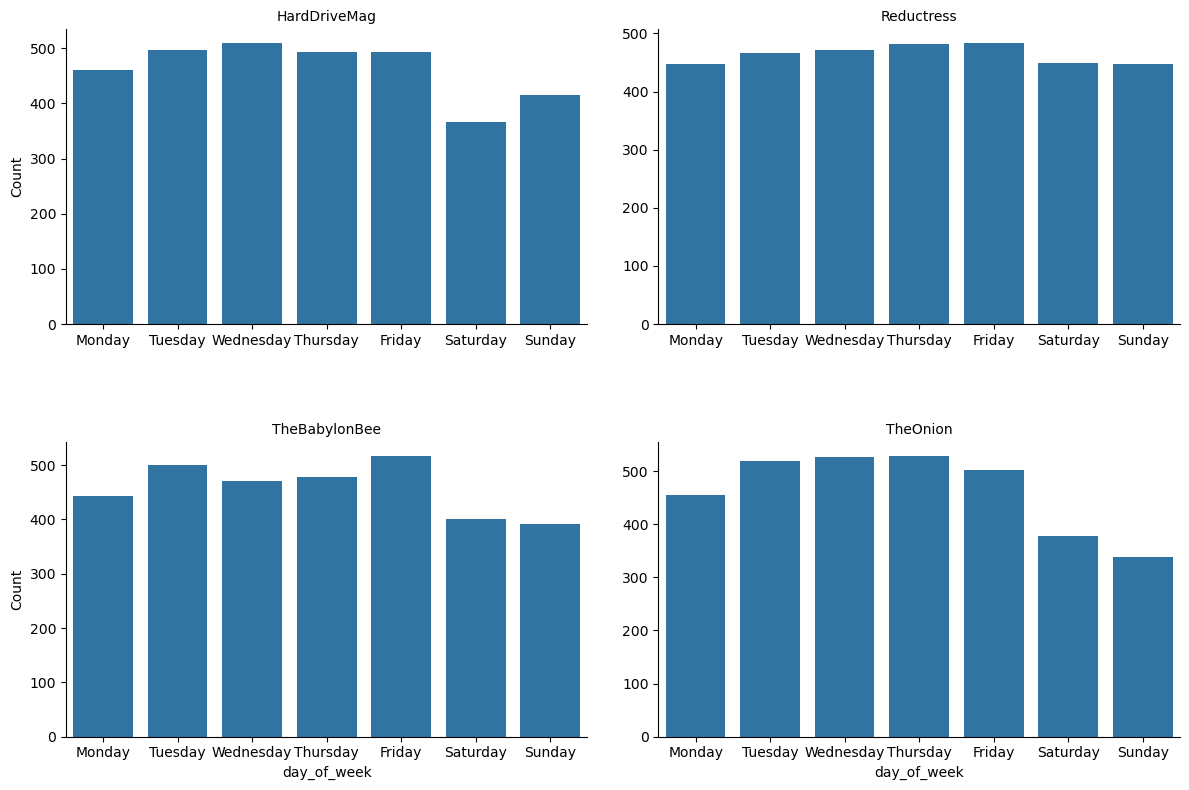

In [88]:
plot_tweet_counts(df, "day_of_week", ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])

### Average Tweet Engagement by Time

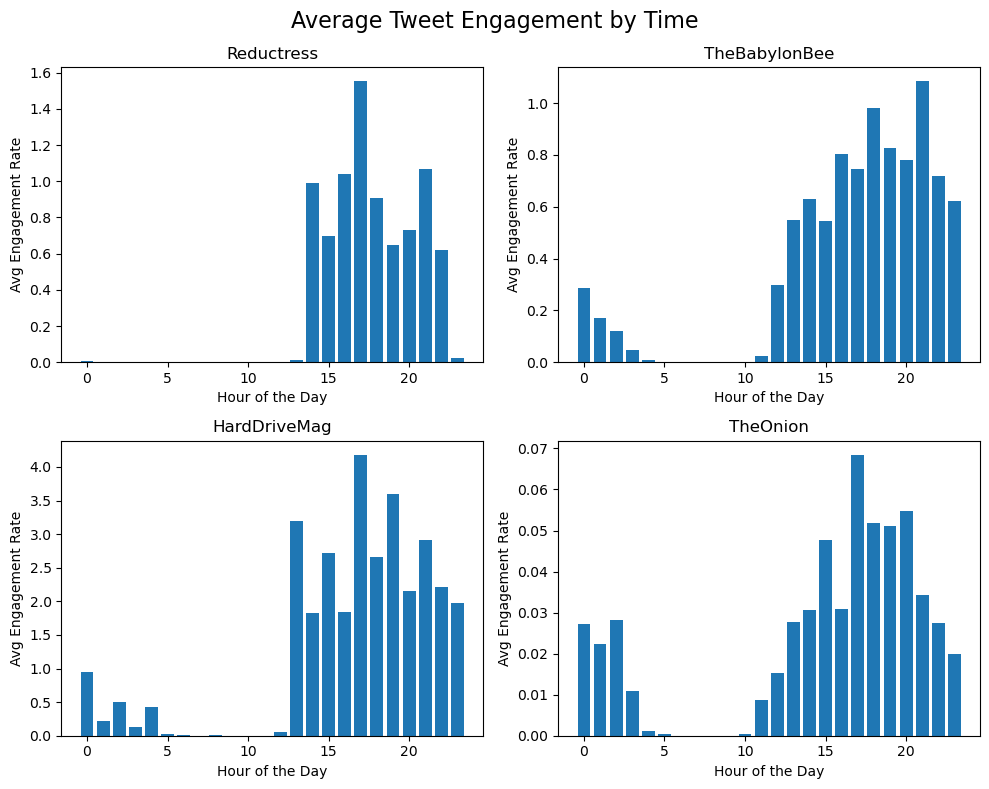

In [89]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

names = ['Reductress', 'TheBabylonBee', 'HardDriveMag', 'TheOnion']

fig.suptitle('Average Tweet Engagement by Time', fontsize=16)

# Plot the counts of retweets for each hour in each subplot
for i, ax in enumerate(axs.flatten()):
    subset_df = df_not_retweets[df_not_retweets['username'] == names[i]]  
    retweet_counts = subset_df.groupby('hour_of_day')['avg_engagement_rate'].sum()
    ax.bar(retweet_counts.index, retweet_counts.values)
    ax.set_title(f'{names[i]}')
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Avg Engagement Rate')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()